In [1]:
from my_plot_tools import plot_confusion_matrix, plot_coefficients

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, f1_score, roc_curve

In [4]:
import warnings
warnings.filterwarnings('ignore')

## Loading Data

In [5]:
def load_news_proportion(df_fake, df_real, fake_pct= None, use_all=False):
    '''
    returns dataset comprised of fake_pct of fake news, or use_all data
    '''
    assert fake_pct or use_all
    max_pct = df_fake.shape[0] / (df_fake.shape[0] + df_real.shape[0])
    
    if use_all:
        return pd.concat([df_real, df_fake], axis=0).sample(frac=1).reset_index(drop=True)
    
    if fake_pct > max_pct:
        n_real = int(((1/fake_pct) - 1) * df_fake.shape[0])
        return pd.concat([df_real.sample(n_real), df_fake], axis=0).sample(frac=1).reset_index(drop=True)
    
    n_fake = int((fake_pct / (1 - fake_pct)) * df_real.shape[0])
    return pd.concat([df_real, df_fake.sample(n_fake)], axis=0).sample(frac=1).reset_index(drop=True)

In [6]:
df_fake = pd.read_csv('./fake_news_set.csv')
df_real = pd.read_csv('./real_news_set.csv')

In [7]:
FAKE_PERCENT = 0.33
df = load_news_proportion(df_fake, df_real, fake_pct=FAKE_PERCENT)
df.groupby('label').size()

label
0    9546
1    4702
dtype: int64

## Using only Body

### Feature Extraction

#### Stop Words

In [8]:
from sklearn.feature_extraction import text

In [9]:
df_stopwords = pd.read_csv("./sw1k.csv") # Standard News Stopwords (1k)
sw1k_stopwords = list(df_stopwords['term'])
source_stopwords = ['cnn', 'reuters', 'npr', 'bbc', 'guardian', 'foxnews', 'humansarefree', 'breitbart'] # common source stopwords
url_stopwords = ['www', 'http', 'https', 'com', 'html', 'october'] # URL stopwords

In [10]:
# Using standard english stopwords, plus additional
my_stop_words = text.ENGLISH_STOP_WORDS.union(url_stopwords, sw1k_stopwords, source_stopwords)

#### Vectorizing Words

In [11]:
vect = TfidfVectorizer(ngram_range=(1,1), stop_words=my_stop_words, max_features=10000)

In [12]:
%%time
X = vect.fit_transform(df['body'].astype(str)).copy()
y = df.loc[:, 'label'].copy()

CPU times: user 7.21 s, sys: 141 ms, total: 7.35 s
Wall time: 7.35 s


#### Train-Test Split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1345)
X_train.shape

(10686, 10000)

### Naive-Bayes

In [14]:
from sklearn.naive_bayes import MultinomialNB

In [15]:
%%time
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

CPU times: user 113 ms, sys: 2.54 ms, total: 116 ms
Wall time: 17.7 ms


In [16]:
print(f"Model Accuracy: {nb_model.score(X_test, y_test):.4f}")
print(f"Model F1-Score: {f1_score(nb_model.predict(X_test), y_test):.4f}")

Model Accuracy: 0.8338
Model F1-Score: 0.6955


Normalized confusion matrix
[[0.96752425 0.03247575]
 [0.43240974 0.56759026]]


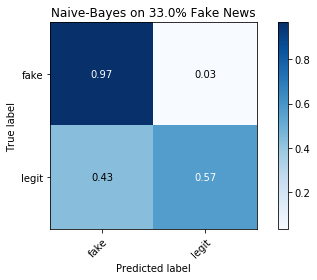

In [17]:
y_pred = nb_model.predict(X_test)
assert y_pred.shape == y_test.shape
plot_confusion_matrix(y_test, y_pred, classes=np.array(['fake', 'legit']), normalize=True,
                      title=f'Naive-Bayes on {FAKE_PERCENT*100}% Fake News');

In [18]:
y_scores = nb_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_scores)

Text(0.5, 0, 'False Positive Rate')

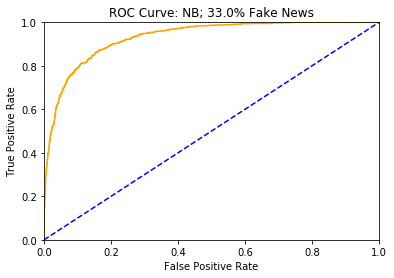

In [19]:
plt.title(f'ROC Curve: NB; {FAKE_PERCENT*100}% Fake News')
plt.plot(fpr, tpr, 'orange')
plt.plot([0, 1], [0, 1],'b--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

### SVM

In [20]:
from sklearn.linear_model import SGDClassifier

In [21]:
%%time
svm_model = SGDClassifier(loss='modified_huber');
svm_model.fit(X_train, y_train);

CPU times: user 148 ms, sys: 2.05 ms, total: 150 ms
Wall time: 34.1 ms


In [22]:
print(f"Model Accuracy: {svm_model.score(X_test, y_test):.4f}")
print(f"Model F1-Score: {f1_score(svm_model.predict(X_test), y_test):.4f}")

Model Accuracy: 0.9166
Model F1-Score: 0.8719


Normalized confusion matrix
[[0.95065373 0.04934627]
 [0.1511335  0.8488665 ]]


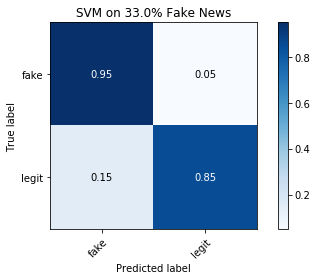

In [23]:
y_pred = svm_model.predict(X_test)
assert y_pred.shape == y_test.shape
plot_confusion_matrix(y_test, y_pred, classes=np.array(['fake', 'legit']), normalize=True,
                      title=f'SVM on {FAKE_PERCENT*100}% Fake News');

In [24]:
y_scores = svm_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_scores)

Text(0.5, 0, 'False Positive Rate')

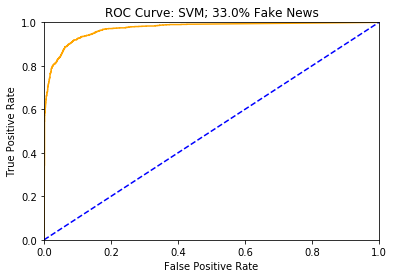

In [25]:
plt.title(f'ROC Curve: SVM; {FAKE_PERCENT*100}% Fake News')
plt.plot(fpr, tpr, 'orange')
plt.plot([0, 1], [0, 1],'b--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

- seems like SVM is good, though I wonder wonder why NB performs much worse (need to learn more about how NB works)

### Cross-Validation

In [26]:
%%time
N = 15
skf = StratifiedKFold(n_splits=N, random_state=None)
svm_scores, nb_scores = [], []
for train_index, test_index in skf.split(X, y): 
    X_train, X_test = X[train_index], X[test_index] 
    y_train, y_test = y[train_index], y[test_index]
    
    svm_model.fit(X_train, y_train)
    fscore = f1_score(svm_model.predict(X_test), y_test)
    score = svm_model.score(X_test, y_test)
    svm_scores.append((score, fscore))
    
    nb_model.fit(X_train, y_train)
    fscore = f1_score(nb_model.predict(X_test), y_test)
    score = nb_model.score(X_test, y_test)
    nb_scores.append((score, fscore))
    
print(f"Mean NB Accuracy Score/Var: {np.mean([s[0] for s in nb_scores]), np.var([s[0] for s in nb_scores])}")
print(f"Mean NB F1 Score/Var: {np.mean([s[1] for s in nb_scores]), np.var([s[1] for s in nb_scores])}\n")

print(f"Mean SVM Accuracy Score/Var: {np.mean([s[0] for s in svm_scores]), np.var([s[0] for s in svm_scores])}")
print(f"Mean SVM F1 Score/Var: {np.mean([s[1] for s in svm_scores]), np.var([s[1] for s in svm_scores])}")

Mean NB Accuracy Score/Var: (0.8434803916291457, 0.00012125367160032766)
Mean NB F1 Score/Var: (0.7173754665246197, 0.0005542005091853274)

Mean SVM Accuracy Score/Var: (0.9190024651823008, 7.413038993741504e-05)
Mean SVM F1 Score/Var: (0.8728612727883234, 0.00020801592061913375)
CPU times: user 4.88 s, sys: 99.4 ms, total: 4.98 s
Wall time: 1.05 s


### Feature analysis

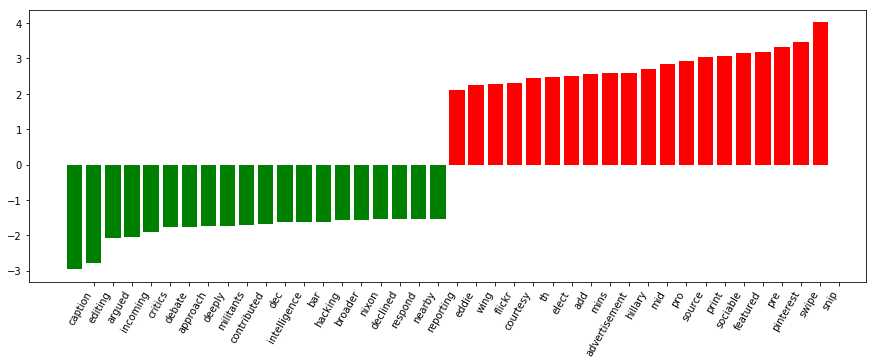

In [27]:
plot_coefficients(svm_model, vect.get_feature_names())

### Assessing Accuracy with Different Percentages of Fake News

In [28]:
percentages = [0.01, 0.02, 0.03, 0.05, 0.1, 0.15, 0.25, 0.33, 0.5]

In [29]:
acc_scores, fscores = [], []
for fake_pct in percentages:
    print(f"{fake_pct} being assessed.")
    df = load_news_proportion(df_fake, df_real, fake_pct=fake_pct)
    vect = TfidfVectorizer(ngram_range=(1,1), stop_words=my_stop_words, max_features=10000)
    
    X = vect.fit_transform(df['body'].astype(str)).copy()
    y = df.loc[:, 'label'].copy()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1345)
    test_model = SGDClassifier();
    test_model.fit(X_train, y_train);
    
    acc_scores.append(test_model.score(X_test, y_test))
    fscores.append(f1_score(test_model.predict(X_test), y_test))

0.01 being assessed.
0.02 being assessed.
0.03 being assessed.
0.05 being assessed.
0.1 being assessed.
0.15 being assessed.
0.25 being assessed.
0.33 being assessed.
0.5 being assessed.


Text(0, 0.5, 'F1 Score')

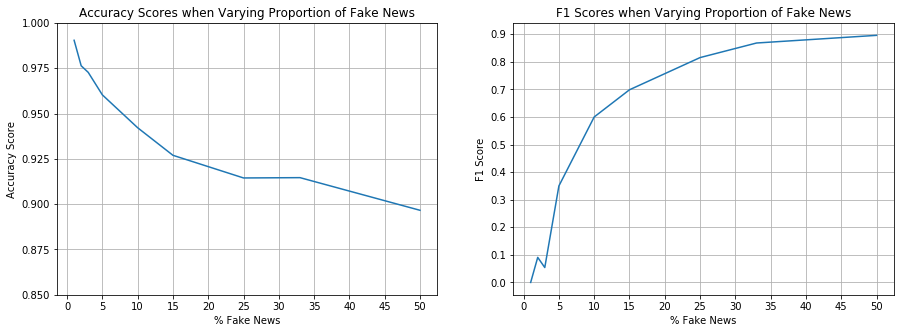

In [30]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
x_label = 100*np.array(percentages)
ax[0].plot(x_label, acc_scores)
ax[0].grid()
ax[0].set_xticks(np.arange(0, 50.1, 5))
ax[0].set_yticks(np.arange(0.85, 1, 0.025))
ax[0].set_title("Accuracy Scores when Varying Proportion of Fake News")
ax[0].set_xlabel("% Fake News")
ax[0].set_ylabel("Accuracy Score")

ax[1].plot(x_label, fscores)
ax[1].grid()
ax[1].set_xticks(np.arange(0, 50.1, 5))
ax[1].set_yticks(np.arange(0, 1, 0.1))
ax[1].set_title("F1 Scores when Varying Proportion of Fake News")
ax[1].set_xlabel("% Fake News")
ax[1].set_ylabel("F1 Score")